# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision
!pip install wheel==0.34.1

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/03/f1/13137340776dd5d5bcfd2574c9c6dfcc7618285035cd77240496e5c1a79b/torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/da/ae/76bd3682465730dea7be21f36a8160a911a470de6f26228904f222e7fefe/torchvision-0.16.2-cp310-cp310-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.8 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for nvidia-cudnn-cu12==8.9.2.26 from https://files.pythonhosted.org/packages/ff/74/a2e2be7fb83aaedec84f391f082cf765dfb635e7caa9b49065f73e4835d8/nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410

In [ ]:
# установка подходящей версии torch

# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install -q http://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl torchvision
import torch

In [70]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Dec 26 21:25:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from collections import Counter
from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn

import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
BATCH_SIZE = 256
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
N_CORES = 2

In [6]:
SEED = 0
torch.manual_seed(SEED) #Устанавливает зерно для генератора случайных чисел PyTorch
torch.cuda.manual_seed_all(SEED) #устанавливает зерно для генератора случайных чисел CUDA
torch.backends.cudnn.deterministic = True #Детерминированный режим гарантирует, что вычисления на GPU будут давать одинаковые результаты при одинаковых входных данных и параметрах модели.
torch.backends.cudnn.benchmark = False #отключение бенчмаркинга который позволяет cuDNN автоматически настраивать параметры для оптимизации производительности
np.random.seed(SEED)

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            test_transforms = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
            ])
            img = Image.open(self.files[index]).convert('RGB')
            return test_transforms(img)
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title, fontsize=10)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Давайте посмотрим на соотношение классов в наборе обучающих данных.

In [10]:
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Мы видим, что набор данных очень несбалансирован. Базовая модель лучше прогнозирует классы с большим количеством образцов. Чтобы решить эту проблему, я собираюсь использовать аугментации. Это также поможет классифицировать персонажей в невертикальных позах.

Я также решил обойтись без набора проверочных данных. В некоторых классах очень мало образцов, и тратить часть их на валидацию — непозволительная роскошь.

Давайте посмотрим на наших героев внутри датасета.

In [12]:
train_dataset = SimpsonsDataset(train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

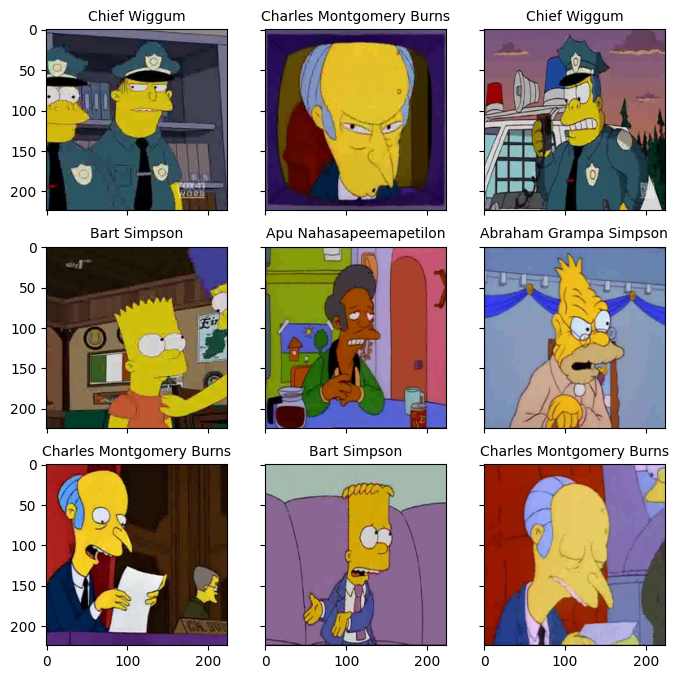

In [88]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,5000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

In [13]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

Давайте посчитаем веса, чтобы выровнять количество семплов: чем меньше семплов — тем больше вес в WeightedRandomSampler.

In [14]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

100%|██████████| 20933/20933 [02:32<00:00, 137.19it/s]


In [15]:
N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

In [16]:
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import random

# train_dataset - ваш объект Dataset

# Определите размер вашего набора данных
dataset_size = len(train_dataset)

# Определите индексы для случайной подвыборки 10% данных
validation_size = int(0.1 * dataset_size)
train_size = dataset_size - validation_size

# Разделите набор данных на тренировочный и валидационный
train, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Создайте DataLoader для валидационного набора
valid_loader = DataLoader(validation_dataset, shuffle=False, num_workers=4)


### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [160]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.out = nn.Linear(96 * 5 * 5, out_features=n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        logits = self.out(x)
        return logits

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_loader, val_loader, model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            val_loss, val_acc = eval_epoch(model, val_loader, loss)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [165]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim

Запустим обучение сети.

In [166]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [168]:
history = train(train_loader, valid_loader, model=simple_cnn, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20,  batch_size=64)

epoch:   5%|▌         | 1/20 [05:12<1:38:50, 312.15s/it]


Epoch 001 train_loss: 1.8188     val_loss 1.6089 train_acc 0.5322 val_acc 0.5738


epoch:  10%|█         | 2/20 [10:21<1:33:08, 310.46s/it]


Epoch 002 train_loss: 0.7321     val_loss 1.1042 train_acc 0.8069 val_acc 0.6928


epoch:  15%|█▌        | 3/20 [15:29<1:27:40, 309.44s/it]


Epoch 003 train_loss: 0.5012     val_loss 0.8901 train_acc 0.8654 val_acc 0.7573


epoch:  20%|██        | 4/20 [20:35<1:22:09, 308.11s/it]


Epoch 004 train_loss: 0.3972     val_loss 0.7125 train_acc 0.8926 val_acc 0.7903


epoch:  25%|██▌       | 5/20 [25:44<1:17:06, 308.45s/it]


Epoch 005 train_loss: 0.3345     val_loss 0.6688 train_acc 0.9083 val_acc 0.8137


epoch:  30%|███       | 6/20 [30:50<1:11:44, 307.49s/it]


Epoch 006 train_loss: 0.2821     val_loss 0.5976 train_acc 0.9222 val_acc 0.8318


epoch:  35%|███▌      | 7/20 [35:56<1:06:30, 306.99s/it]


Epoch 007 train_loss: 0.2485     val_loss 0.5026 train_acc 0.9315 val_acc 0.8586


epoch:  40%|████      | 8/20 [41:03<1:01:25, 307.13s/it]


Epoch 008 train_loss: 0.1908     val_loss 0.4104 train_acc 0.9483 val_acc 0.8901


epoch:  45%|████▌     | 9/20 [46:14<56:30, 308.19s/it]  


Epoch 009 train_loss: 0.1678     val_loss 0.3800 train_acc 0.9546 val_acc 0.8963


epoch:  50%|█████     | 10/20 [51:21<51:20, 308.03s/it]


Epoch 010 train_loss: 0.1599     val_loss 0.3627 train_acc 0.9567 val_acc 0.8963


epoch:  55%|█████▌    | 11/20 [56:31<46:15, 308.43s/it]


Epoch 011 train_loss: 0.1568     val_loss 0.3770 train_acc 0.9582 val_acc 0.8915


epoch:  60%|██████    | 12/20 [1:01:40<41:08, 308.56s/it]


Epoch 012 train_loss: 0.1459     val_loss 0.3482 train_acc 0.9599 val_acc 0.8997


epoch:  65%|██████▌   | 13/20 [1:06:48<35:59, 308.44s/it]


Epoch 013 train_loss: 0.1438     val_loss 0.3497 train_acc 0.9599 val_acc 0.8987


epoch:  70%|███████   | 14/20 [1:11:57<30:51, 308.64s/it]


Epoch 014 train_loss: 0.1408     val_loss 0.3041 train_acc 0.9612 val_acc 0.9054


epoch:  75%|███████▌  | 15/20 [1:17:04<25:41, 308.30s/it]


Epoch 015 train_loss: 0.1366     val_loss 0.3435 train_acc 0.9622 val_acc 0.9011


epoch:  80%|████████  | 16/20 [1:22:10<20:29, 307.41s/it]


Epoch 016 train_loss: 0.1349     val_loss 0.3266 train_acc 0.9631 val_acc 0.9059


epoch:  85%|████████▌ | 17/20 [1:27:16<15:21, 307.02s/it]


Epoch 017 train_loss: 0.1348     val_loss 0.2988 train_acc 0.9631 val_acc 0.9173


epoch:  90%|█████████ | 18/20 [1:32:23<10:14, 307.01s/it]


Epoch 018 train_loss: 0.1349     val_loss 0.3101 train_acc 0.9632 val_acc 0.9040


epoch:  95%|█████████▌| 19/20 [1:37:32<05:07, 307.70s/it]


Epoch 019 train_loss: 0.1357     val_loss 0.3106 train_acc 0.9627 val_acc 0.9135


epoch: 100%|██████████| 20/20 [1:42:36<00:00, 307.82s/it]


Epoch 020 train_loss: 0.1281     val_loss 0.3104 train_acc 0.9646 val_acc 0.9111


Построим кривые обучения

In [169]:
loss, acc, val_loss, val_acc = zip(*history)

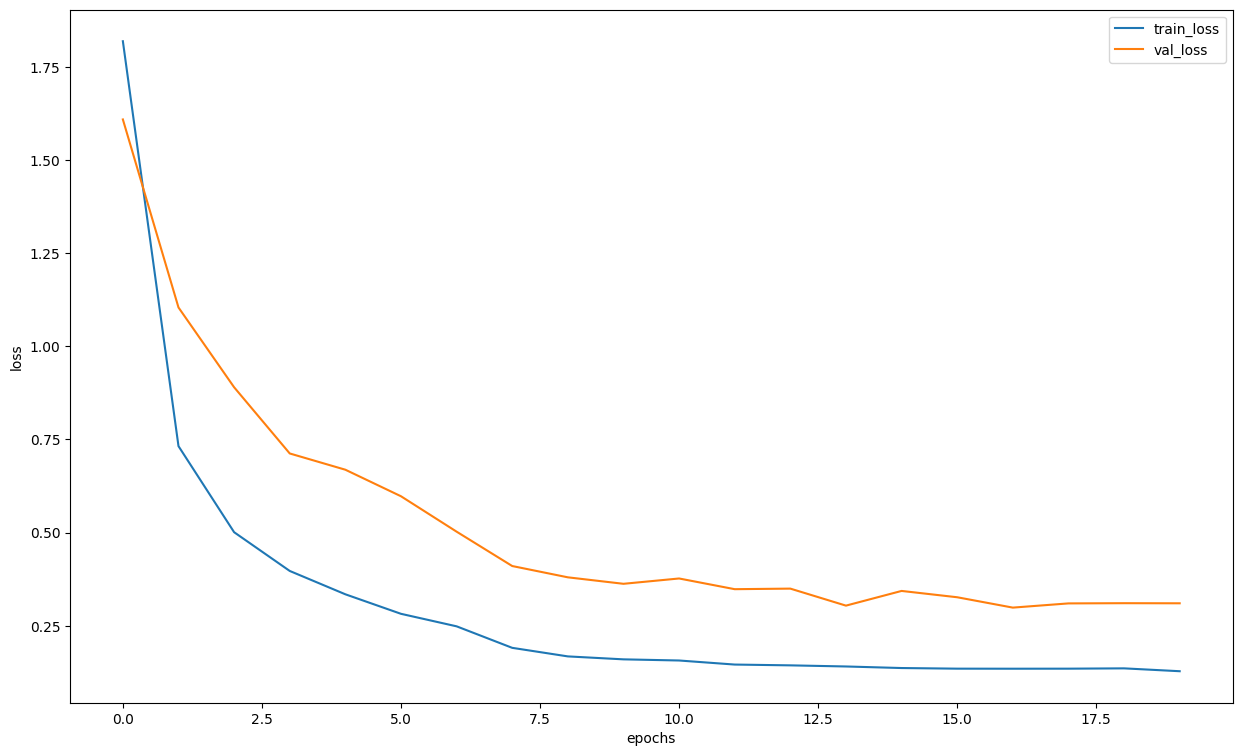

In [170]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = F.softmax(logit, dim=-1).numpy()
    return probs

In [186]:
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(simple_cnn, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [187]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("baseline_aug.csv", index=False)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [200]:
train_dataset.classes[0]

'abraham_grampa_simpson'

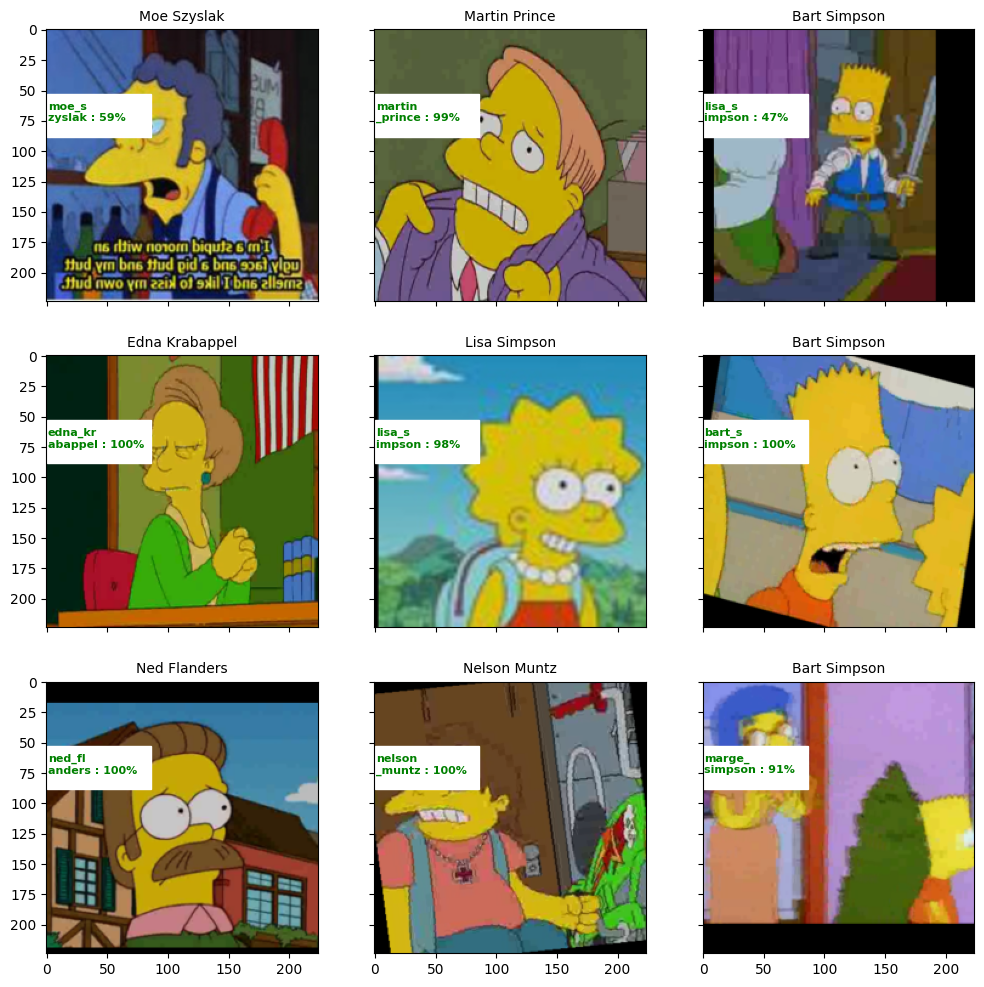

In [205]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val, label = validation_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.classes[label].split('_')))

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = train_dataset.classes[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='green',fontweight='bold')

### Анализ неправильно классифицированных изображений

In [207]:
# запишем в список неверно классифицированные изображения
# add incorrectly classified images to the list
incorrect_predictions = []

for idx in range(len(validation_dataset)):
    img, label = validation_dataset[idx]
    predicted_probs = predict_one_sample(simple_cnn, img.unsqueeze(0))
    predicted_label = np.argmax(predicted_probs)
    
    if predicted_label != label:
        actual_class = train_dataset.classes[label]
        predicted_class = train_dataset.classes[predicted_label]
        incorrect_predictions.append({
            'image_index': idx,
            'actual_class': actual_class,
            'predicted_class': predicted_class,
            'predicted_probs': predicted_probs
        })

In [209]:
import pandas as pd
df_incorrect = pd.DataFrame(incorrect_predictions).drop(columns=['predicted_class'])
class_counts = df_incorrect.groupby(['actual_class']).size().reset_index(name='count')
class_counts_sorted = class_counts.sort_values(by='count', ascending=False)
class_counts_sorted

,actual_class,count
7,homer_simpson,44
10,lisa_simpson,29
2,bart_simpson,28
3,charles_montgomery_burns,13
13,moe_szyslak,13
14,ned_flanders,12
15,principal_skinner,10
12,milhouse_van_houten,9
11,marge_simpson,8
0,abraham_grampa_simpson,7


Посмотрим на ошибки предсказаний для класса homer_simpson.


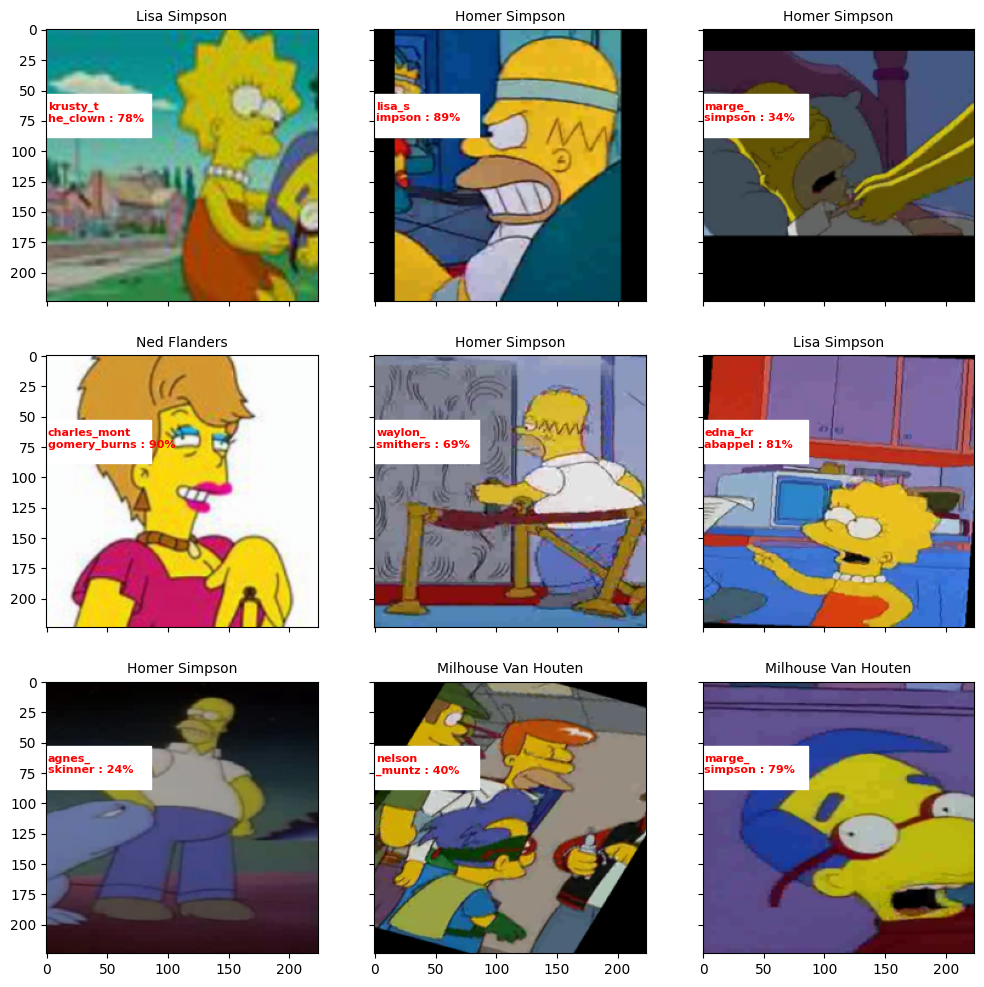

In [211]:
# Plot incorrect predictions
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x, incorrect_info in zip(ax.flatten(), incorrect_predictions):
    idx = incorrect_info['image_index']
    img, label = validation_dataset[idx]

    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.classes[label].split('_')))
    
    imshow(img.data.cpu(), title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")

    actual_class = incorrect_info['actual_class']
    predicted_probs = incorrect_info['predicted_probs']
    predicted_label = train_dataset.classes[np.argmax(predicted_probs)]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_proba = np.max(predicted_probs) * 100

    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
               verticalalignment='top', fontsize=8, color='red', fontweight='bold')

In [218]:
n_classes = len(np.unique(train_val_labels))

model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(8, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 96, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),

    # Additional layers from the second code snippet
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=4096, out_features=n_classes, bias=True),
).to(DEVICE)

print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")


We will classify 42 classes
Model: Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=2400, out_features=4096, bias=True)
  (17): ReLU(inplace=True)
  (18): Linear(in_features=4096, out_features=4096, bia

In [219]:
model = model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [220]:
history = train(train_loader, valid_loader, model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20,  batch_size=64)

epoch:   5%|▌         | 1/20 [05:23<1:42:30, 323.70s/it]


Epoch 001 train_loss: 1.5929     val_loss 1.1658 train_acc 0.5662 val_acc 0.6703


epoch:  10%|█         | 2/20 [10:42<1:36:16, 320.93s/it]


Epoch 002 train_loss: 0.3802     val_loss 0.5346 train_acc 0.8913 val_acc 0.8337


epoch:  15%|█▌        | 3/20 [16:04<1:31:04, 321.46s/it]


Epoch 003 train_loss: 0.2052     val_loss 0.4006 train_acc 0.9398 val_acc 0.8748


epoch:  20%|██        | 4/20 [21:26<1:25:43, 321.48s/it]


Epoch 004 train_loss: 0.1464     val_loss 0.2560 train_acc 0.9565 val_acc 0.9202


epoch:  25%|██▌       | 5/20 [26:47<1:20:21, 321.41s/it]


Epoch 005 train_loss: 0.1079     val_loss 0.2113 train_acc 0.9678 val_acc 0.9269


epoch:  30%|███       | 6/20 [32:06<1:14:47, 320.54s/it]


Epoch 006 train_loss: 0.0842     val_loss 0.1829 train_acc 0.9752 val_acc 0.9455


epoch:  35%|███▌      | 7/20 [37:24<1:09:18, 319.87s/it]


Epoch 007 train_loss: 0.0682     val_loss 0.1446 train_acc 0.9791 val_acc 0.9556


epoch:  40%|████      | 8/20 [42:38<1:03:35, 317.97s/it]


Epoch 008 train_loss: 0.0314     val_loss 0.0678 train_acc 0.9907 val_acc 0.9790


epoch:  45%|████▌     | 9/20 [47:59<58:25, 318.72s/it]  


Epoch 009 train_loss: 0.0222     val_loss 0.0500 train_acc 0.9938 val_acc 0.9861


epoch:  50%|█████     | 10/20 [53:30<53:47, 322.75s/it]


Epoch 010 train_loss: 0.0180     val_loss 0.0440 train_acc 0.9949 val_acc 0.9909


epoch:  55%|█████▌    | 11/20 [59:12<49:16, 328.44s/it]


Epoch 011 train_loss: 0.0145     val_loss 0.0350 train_acc 0.9959 val_acc 0.9904


epoch:  60%|██████    | 12/20 [1:04:32<43:28, 326.03s/it]


Epoch 012 train_loss: 0.0128     val_loss 0.0229 train_acc 0.9963 val_acc 0.9938


epoch:  65%|██████▌   | 13/20 [1:09:55<37:55, 325.06s/it]


Epoch 013 train_loss: 0.0105     val_loss 0.0319 train_acc 0.9971 val_acc 0.9914


epoch:  70%|███████   | 14/20 [1:15:20<32:30, 325.08s/it]


Epoch 014 train_loss: 0.0105     val_loss 0.0295 train_acc 0.9969 val_acc 0.9914


epoch:  75%|███████▌  | 15/20 [1:20:40<26:57, 323.47s/it]


Epoch 015 train_loss: 0.0092     val_loss 0.0275 train_acc 0.9974 val_acc 0.9919


epoch:  80%|████████  | 16/20 [1:26:00<21:29, 322.44s/it]


Epoch 016 train_loss: 0.0090     val_loss 0.0305 train_acc 0.9974 val_acc 0.9919


epoch:  85%|████████▌ | 17/20 [1:31:24<16:08, 322.79s/it]


Epoch 017 train_loss: 0.0080     val_loss 0.0199 train_acc 0.9978 val_acc 0.9938


epoch:  90%|█████████ | 18/20 [1:36:43<10:43, 321.88s/it]


Epoch 018 train_loss: 0.0101     val_loss 0.0286 train_acc 0.9973 val_acc 0.9919


epoch:  95%|█████████▌| 19/20 [1:42:04<05:21, 321.61s/it]


Epoch 019 train_loss: 0.0079     val_loss 0.0206 train_acc 0.9978 val_acc 0.9943


epoch: 100%|██████████| 20/20 [1:47:25<00:00, 322.26s/it]


Epoch 020 train_loss: 0.0087     val_loss 0.0238 train_acc 0.9977 val_acc 0.9924


![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)

In [225]:
loss2, acc2, val_loss2, val_acc2 = zip(*history)

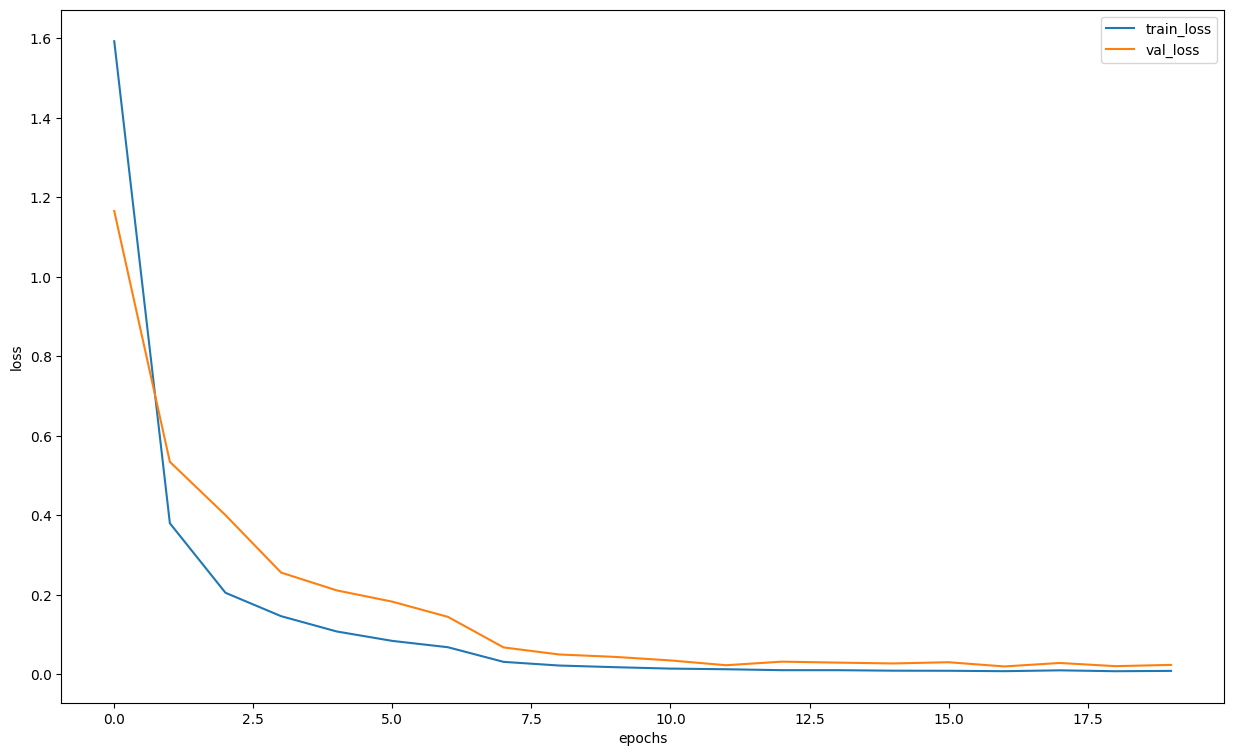

In [226]:
plt.figure(figsize=(15, 9))
plt.plot(loss2, label="train_loss")
plt.plot(val_loss2, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [227]:
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [228]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("baseline_aug2.csv", index=False)

In [25]:
n_classes = len(np.unique(train_val_labels))

model_addition = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(8, 16, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 96, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),

    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),

    # Additional layers
    nn.Linear(in_features=4096, out_features=2048, bias=True),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=1024, out_features=n_classes, bias=True),
).to(DEVICE)

print("We will classify {} classes".format(n_classes))
print(f"Model: {model_addition}")


We will classify 42 classes
Model: Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=2400, out_features=4096, bias=True)
  (17): ReLU(inplace=True)
  (18): Linear(in_features=4096, out_features=4096, bia

In [26]:
model_addition = model_addition.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_addition.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
history = train(train_loader, valid_loader, model=model_addition, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20,  batch_size=64)

epoch:   5%|▌         | 1/20 [05:15<1:39:50, 315.28s/it]


Epoch 001 train_loss: 2.8065     val_loss 2.4812 train_acc 0.2352 val_acc 0.2986


epoch:  10%|█         | 2/20 [10:19<1:32:36, 308.69s/it]


Epoch 002 train_loss: 1.1177     val_loss 1.2829 train_acc 0.6901 val_acc 0.6302


epoch:  15%|█▌        | 3/20 [15:23<1:26:55, 306.78s/it]


Epoch 003 train_loss: 0.5252     val_loss 0.8301 train_acc 0.8506 val_acc 0.7477


epoch:  20%|██        | 4/20 [20:25<1:21:14, 304.64s/it]


Epoch 004 train_loss: 0.3306     val_loss 0.6171 train_acc 0.9028 val_acc 0.8146


epoch:  25%|██▌       | 5/20 [25:36<1:16:44, 306.97s/it]


Epoch 005 train_loss: 0.2417     val_loss 0.4320 train_acc 0.9292 val_acc 0.8705
